# Notebook Imports

In [1]:
from os import walk
from os.path  import join

import pandas as pd
import numpy as np


In [2]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split




In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


# Constants

In [4]:
EXAMPLE_FILE = 'SpamData\\01_Processing\\practice_email.txt'

EASY_NONSPAM1 = 'SpamData\\01_Processing\\\spam_assassin_corpus\\easy_ham_1'
EASY_NONSPAM2 = 'SpamData\\01_Processing\\\spam_assassin_corpus\\easy_ham_2'
SPAM1 = 'SpamData\\01_Processing\\\spam_assassin_corpus\\spam_1'
SPAM2 = 'SpamData\\01_Processing\\\spam_assassin_corpus\\spam_2'

DATA_JSON_FILE = 'SpamData\\01_Processing\\\email_text.json'

WORD_ID_FILE = 'SpamData\\01_Processing\\\word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData\\01_Processing\\train_data.txt'
TEST_DATA_FILE = 'SpamData\\01_Processing\\test_data.txt'
SPAM_CAT = 1
HAM_CAT =0
VOCAB_SIZE = 2500
 


# Reading Files

In [5]:
stream = open(EXAMPLE_FILE,encoding='latin-1')
message = stream.read()
stream.close()



Encoding, ASCII

In [6]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [7]:
stream = open(EXAMPLE_FILE,encoding='latin-1')
#message = stream.read()
is_body = False # flage
lines =[]

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        
        is_body = True
        
stream.close()

email_body = ' \n '.join(lines)

#print(email_body)
#print(lines)

# Generator Function

In [9]:
def gerate_squares(N):
    for my_number in range(N):
        yield my_number **2

In [10]:
gerate_squares(3)

<generator object gerate_squares at 0x0000026BF70ECD58>

In [11]:
for i in gerate_squares(5):
    print(i,end='->')

0->1->4->9->16->

# Email body extraction

In [12]:

def email_body_generator(path):
    
    # root is path dir 
    for root,dirnames,filenames in walk(path):
        for file in filenames:
            
            file_path = join(root,file)
            stream = open(file_path,encoding='latin-1') 
            is_body = False # flage
            lines=[]
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
            stream.close()
            
            email_body = ' \n '.join(lines)
            
            yield file,email_body
            
            
            
        

In [13]:

def df_from_directory(path,classification):
    
    rows = []
    row_names=[]
    
    for file_name,email_body in email_body_generator (path):
        
        rows.append({'MESSAGE': email_body,'CATEGORY':classification})
        #rows.append([email_body,classification])
        row_names.append(file_name)
        
    
    return pd.DataFrame(rows,index=row_names)


In [14]:
spam_emails = df_from_directory(SPAM1,SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM2,SPAM_CAT))
spam_emails.shape

(1898, 2)

In [15]:
ham_emails = df_from_directory(EASY_NONSPAM1,HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM2,HAM_CAT))
ham_emails.shape

(3901, 2)

In [16]:
ham_emails.head()

,CATEGORY,MESSAGE
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\n \n Tassos Papadopoulos, the..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n \n \n \n ...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n \n \n \n Alr...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."


In [17]:
data = pd.concat([spam_emails,ham_emails])
data.shape

(5799, 2)

# Data Cleaning: Checking for Missing Values

In [ ]:
data['MESSAGE'].isnull().value_counts()

In [ ]:
data['MESSAGE'].isnull().values.any()

In [ ]:
(data.MESSAGE.str.len() == 0).any()

In [ ]:
(data.MESSAGE.str.len() == 0).value_counts()

In [ ]:
(data.MESSAGE.str.len() == 0).sum()

### Locate empty emails

In [ ]:
data[data.MESSAGE.str.len() == 0].index

# Remove System file entryes

In [19]:
data.drop(['cmds'],inplace=True)

In [20]:
data.shape

(5796, 2)

# Add Doc IDs to track emails in Datasets

In [21]:
document_ids = range(0,len(data.index))
document_ids

range(0, 5796)

In [22]:
data['DOC_ID'] = document_ids
data.head()

,CATEGORY,MESSAGE,DOC_ID
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",0
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n \n http://www.a...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n \n http://www.a...,2
00004.eac8de8d759b7e74154f142194282724,1,##############################################...,3
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n \n 1) Slim D...,4


In [23]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID',inplace = True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n \n http://www.a...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n \n http://www.a...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n \n 1) Slim D...,00005.57696a39d7d84318ce497886896bf90d


In [24]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5791,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5794,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,0,"Hi there,\n \n \n \n Now this is probably of n...",01400.f897f0931e461e7b2e964d28e927c35e


# Save to file using Pandas

In [25]:
data.to_json(DATA_JSON_FILE)

# Number of spam messages Visuasilisd (Pie charts)

In [26]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [27]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]


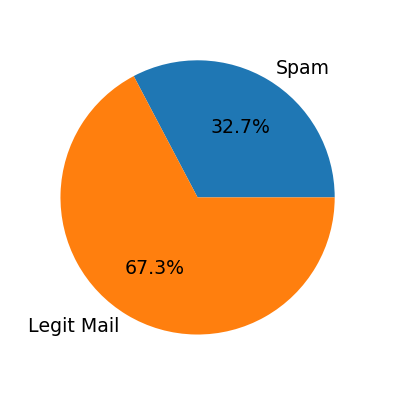

In [28]:
category_names = ['Spam','Legit Mail']
sizes = [amount_of_spam,amount_of_ham]

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels = category_names,textprops={'fontsize':6},
       autopct='%1.1f%%',)
plt.show()

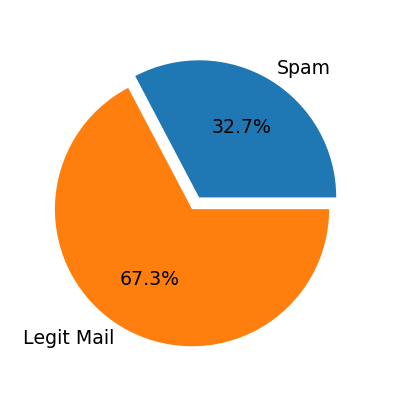

In [29]:
category_names = ['Spam','Legit Mail']
sizes = [amount_of_spam,amount_of_ham]

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels = category_names,textprops={'fontsize':6},
       autopct='%1.1f%%',explode=[0,0.1])

# draw a circle


plt.show()

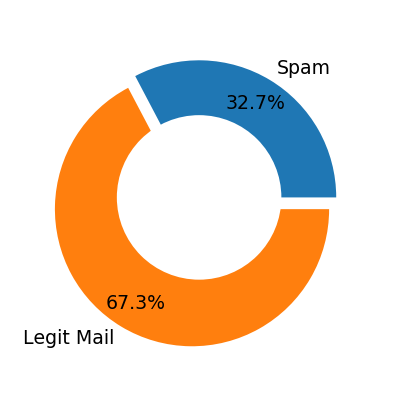

In [30]:
category_names = ['Spam','Legit Mail']
sizes = [amount_of_spam,amount_of_ham]

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels = category_names,textprops={'fontsize':6},
       autopct='%1.1f%%',explode=[0,0.1],pctdistance=0.8)

# draw a circle
center_circle =plt.Circle((0,0),radius = 0.6,fc='white')
plt.gca().add_artist(center_circle)

plt.show()

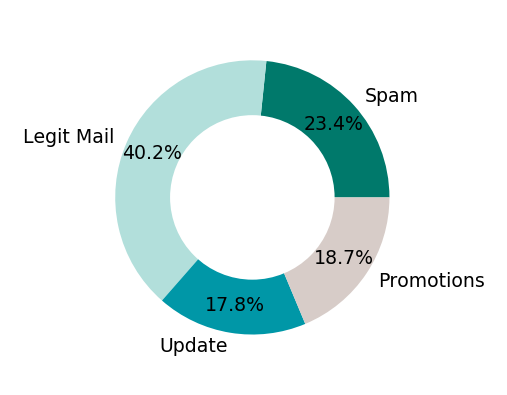

In [31]:
category_names = ['Spam','Legit Mail','Update','Promotions']
#sizes = [amount_of_spam,amount_of_ham]
sizes = [25,43,19,20]

custom_colors = ['#00796B','#B2DFDB','#0097A7','#D7CCC8']

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels = category_names,textprops={'fontsize':6},
       autopct='%1.1f%%',pctdistance=0.8,colors= custom_colors)

# draw a circle
center_circle =plt.Circle((0,0),radius = 0.6,fc='white')
plt.gca().add_artist(center_circle)

plt.show()

# Natural Language Processing

## Text Preprocessing

## Converting to lower case
## Tokenising 
## Removing stop words
## Stripping out HTML tags
## Word Stemming
## Removing punctuation
##

### Download the NLTK Resources(Tolenizer & Stopwords)

In [32]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\AI\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\AI\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

# Tokenising

## Removing stop words

In [35]:
stop_words = set(stopwords.words('english'))

In [36]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


# Word Stems and Stemming

In [37]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')


filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


# Removing Punctuion

In [38]:
'p'.isalpha()

True

In [39]:
'?'.isalpha()

False

In [40]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. ??? \
      Nobody expects the Spanish Inquisition!'

words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


# Removing HTML Tags from Emails

In [41]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!
 
 http://www.adclick.ws/p.cfm?o=315&amp;s=pk007
 
 
 
 2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days
 
 http://www.adclick.ws/p.cfm?o=249&amp;s=pk007
 
 
 
 3) Get the Child Support You Deserve - Free Legal Advice
 
 http://www.adclick.ws/p.cfm?o=245&amp;s=pk002
 
 
 
 4) Join the Web's Fastest Growing Singles Community
 
 http://www.adclick.ws/p.cfm?o=259&amp;s=pk007
 
 
 
 5) Start Your Private Photo Album Online!
 
 http://www.adclick.ws/p.cfm?o=283&amp;s=pk007
 
 
 
 Have a Wonderful Day,
 
 Offer Manager
 
 PrizeMama
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 If you wish to leave this list please use the link below.
 
 http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [42]:
soup.get_text()

"1) Fight The Risk of Cancer!\n \n http://www.adclick.ws/p.cfm?o=315&s=pk007\n \n \n \n 2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n \n http://www.adclick.ws/p.cfm?o=249&s=pk007\n \n \n \n 3) Get the Child Support You Deserve - Free Legal Advice\n \n http://www.adclick.ws/p.cfm?o=245&s=pk002\n \n \n \n 4) Join the Web's Fastest Growing Singles Community\n \n http://www.adclick.ws/p.cfm?o=259&s=pk007\n \n \n \n 5) Start Your Private Photo Album Online!\n \n http://www.adclick.ws/p.cfm?o=283&s=pk007\n \n \n \n Have a Wonderful Day,\n \n Offer Manager\n \n PrizeMama\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n If you wish to leave this list please use the link below.\n \n http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n \n \n"

## Functions for Email Processing

In [43]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [44]:
#clean_message(email_body)

In [45]:
# Challenge: Modify function to remove HTML tags. Then test on Email with DOC_ID 2. 
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

# Apply Cleaning and Tokenisation to all message

### Slicing Dataframes and Series & Creating Subsets

In [46]:
data.iloc[5:11]

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n \n <head>\n \n <title>ReliaQuote - Sa...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n \n Want To Stop...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,1,"Dear ricardo1 ,\n \n \n \n <html>\n \n <body>\...",00010.445affef4c70feec58f9198cfbc22997
10,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e


In [47]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)

In [48]:
#data.iat[2, 2]

In [49]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\AI\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 51.7 s


In [50]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [51]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [52]:
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n \n http://www.a...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n \n http://www.a...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n \n 1) Slim D...,00005.57696a39d7d84318ce497886896bf90d


In [53]:
data['DOC_ID'] = range(0,len(data.index.values))

In [54]:
data.set_index('DOC_ID',inplace=True)

In [55]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

### Subsetting a Series with an Inde

In [56]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [57]:
type(nested_list)

pandas.core.series.Series

In [58]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [59]:
nested_list_ham.shape

(3900,)

In [60]:
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [61]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [62]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20751

In [63]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [64]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the spam messages

13282

In [65]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

# Creating a word cloud

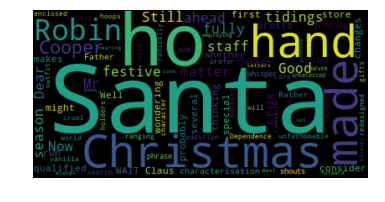

In [66]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [67]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [ ]:
example_corpus

In [68]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [ ]:
#rgb_array.shape

In [ ]:
#rgb_array[1023, 2047]

In [ ]:
#rgb_array[500, 1000]

# Word Cloud of Ham and Spam Messages

# Generate Vocabulary & Dictionary

In [69]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list=[item for sublist in stemmed_nested_list for item in sublist ]

In [71]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words',unique_words.shape[0])
unique_words.head()

Nr of unique words 27302


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [72]:
frequent_words = unique_words[0:VOCAB_SIZE]

print('Top ten frequent words are  \n')
print(frequent_words[0:9])

Top ten frequent words are  

http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
dtype: int64


In [73]:
type(frequent_words)

pandas.core.series.Series

# Create Vocabulary DataFrame with WORD_ID

In [74]:
word_ids = list(range(0,VOCAB_SIZE))

vocab = pd.DataFrame({'VOCAB_WORD':frequent_words.index.values},index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


# Save the Vocabulary as a CSV file

In [75]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name,
             header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a word is part of the Vocabulary

In [76]:
ex_word = ['machine','learn','fun','learn','data','science',
          'app','brewery']

In [77]:
for word in ex_word:
    
    if word in set(vocab.VOCAB_WORD):
        print('Yes',word)
    else:
        print('NO',word)
#type(vocab.VOCAB_WORD.values)

NO machine
Yes learn
Yes fun
Yes learn
Yes data
NO science
Yes app
NO brewery


In [78]:
stemmed_email = pd.DataFrame(stemmed_nested_list)
count=[]
for list in stemmed_email.MESSAGE:
    count.append(len(list))
    
stemmed_email['WORD_COUNT'] = count
    

In [79]:
stemmed_email.WORD_COUNT.argmax()

C:\Users\AI\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


5775

In [81]:
#stemmed_email.loc['01380.e3fad5af747d3a110008f94a046bf31b']

In [82]:
len(stemmed_email.MESSAGE)

5796

In [83]:
stemmed_email.WORD_COUNT.max()

7665

In [ ]:
#stemmed_nested_list[np.argmax(count)]

# Genearate Features & a Sparse Matrix

### Creating a DataFrame with one Word per column

In [84]:
type(stemmed_nested_list)

pandas.core.series.Series

In [85]:
word_columns_df= pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [87]:
word_columns_df.shape

(5796, 7665)

# Splitting the data into a Traing and Testing Dataset

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [90]:
print(X_train.shape)

(4057, 7665)


In [91]:
print(X_test.shape)

(1739, 7665)


In [92]:
X_test.index.name = X_train.index.name = 'DOC_ID'

In [93]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [94]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [95]:
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n \n http://www.a...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n \n http://www.a...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n \n 1) Slim D...,00005.57696a39d7d84318ce497886896bf90d


# Create a Sparse Matrix for the Training Data

In [96]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [97]:
type(word_index[8])

str

In [98]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [99]:
def make_sparse_matrix(df,indexed_words,labels):
    
    """
    Returns sparse matrix as dataframe.
    df:
      
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    
    word_set = set(indexed_words)
    dict_list =[]
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL':category,'DOC_ID':doc_id,
                       'OCCURENCE':1,'WORD_ID':word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [100]:
%%time

sparse_train_df = make_sparse_matrix(X_train,word_index,y_train)

Wall time: 6min 11s


In [101]:
%%time

sparse_test_df = make_sparse_matrix(X_test,word_index,y_test)

Wall time: 2min 31s


In [102]:
sparse_train_df.head()

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4844,0,1,266
1,4844,0,1,1257
2,4844,0,1,508
3,4844,0,1,310
4,4844,0,1,254


In [103]:
sparse_train_df.shape

(430952, 4)

In [104]:
sparse_train_df[-5:]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
430947,860,1,1,47
430948,860,1,1,1434
430949,860,1,1,26
430950,860,1,1,19
430951,860,1,1,126


# Combine Occurrences with the Pandas groupby() method

In [105]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [106]:
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
8      2       1              1
       3       1              4
       4       1              2
       5       1              1
       6       1              2

In [ ]:
vocab.at[3,'VOCAB_WORD']

In [107]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n \n <HTML><HEAD>\n \n <META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n \n ype>\n \n <META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n \n <BODY><!-- Inserted by Calypso -->\n \n <TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n \n ules=3Dnone \n \n style=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n \n   <TBODY>\n \n   <TR>\n \n     <TD colSpan=3D3>\n \n       <HR color=3Dblack noShade SIZE=3D1>\n \n     </TD></TR></TD></TR>\n \n   <TR>\n \n     <TD colSpan=3D3>\n \n       <HR color=3Dblack noShade SIZE=3D1>\n \n     </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n \n  --><FONT \n \n color=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n \n /TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n \n face=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n \n <CENTER>Save up to 70% on Life Insuranc

In [108]:
train_grouped = train_grouped.reset_index()

In [109]:
test_grouped = test_grouped.reset_index()

In [110]:
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [111]:
train_grouped.shape

(258303, 4)

# Save Traing data as txt file

In [112]:
np.savetxt(TRAINING_DATA_FILE,train_grouped,fmt='%d')

In [113]:
np.savetxt(TEST_DATA_FILE,test_grouped,fmt='%d')

# Pre-Processing subtleties and Checking your understanding

In [ ]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [ ]:
len(test_doc_ids)

In [ ]:
len(X_test)